In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

data_path = "data/features/genimage/jpg100"
suffix = "features/extraction_params/train/features_RGB.csv"
biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_train, midjourney_train])
combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

datasets_train = {
    "biggan": biggan_train,
    "vqdm": vqdm_train,
    "sdv5": sdv5_train,
    "wukong": wukong_train,
    "adm": adm_train,
    "glide": glide_train,
    "midjourney": midjourney_train,
    "mid_sd": mid_sd,
    "combined": combined_train,
}

In [4]:
suffix = "features/extraction_params/val/features_RGB.csv"
biggan_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_test = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_test = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_test, midjourney_test])
combined_test = pd.concat([biggan_test, vqdm_test, sdv5_test, wukong_test, adm_test, glide_test, midjourney_test])

datasets_test = {
    "biggan": biggan_test,
    "vqdm": vqdm_test,
    "sdv5": sdv5_test,
    "wukong": wukong_test,
    "adm": adm_test,
    "glide": glide_test,
    "midjourney": midjourney_test,
    "mid_sd": mid_sd,
    "combined": combined_test,
}

## Data preparation

In [5]:
def drop_columns(df, drop_only_diagnostic=False):
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            df.drop(column, axis=1, inplace=True)
        elif 'diagnostics' in column:
            df.drop(column, axis=1, inplace=True)
        elif 'Mask' in column:
            df.drop(column, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [6]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [7]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}

y_train = {}
y_val = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)

### Scale the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in datasets_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in datasets_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED)
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: biggan

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: vqdm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9940625
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.935625


Training set: sdv5

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.99875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9865625


Training set: wukong

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9984375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9759375


Training set: adm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9896875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.91375


Training set: mid_sd

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.998125
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.96390625
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9075


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9423214285714285
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9049553571428571
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.8521875


## Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [11]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9962
F1: 0.9962
Precision: 0.9963
Recall: 0.9962
MCC: 0.9925

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5012
F1: 0.3405
Precision: 0.5503
Recall: 0.5012
MCC: 0.0159

Model: RandomForestClassifier
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354

Model: LinearSVC
Accuracy: 0.5062
F1: 0.3471
Precision: 0.7516
Recall: 0.5062
MCC: 0.0793


Validation set: sdv5



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354

Model: LinearDiscriminantAnalysis
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354

Model: LinearSVC
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5038
F1: 0.3416
Precision: 0.7509
Recall: 0.5038
MCC: 0.0614

Model: LinearDiscriminantAnalysis
Accuracy: 0.5138
F1: 0.3632
Precision: 0.7535
Recall: 0.5138
MCC: 0.1181

Model: RandomForestClassifier
Accuracy: 0.5038
F1: 0.3416
Precision: 0.7509
Recall: 0.5038
MCC: 0.0614

Model: LinearSVC

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3399
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5012
F1: 0.3361
Precision: 0.7503
Recall: 0.5012
MCC: 0.0354

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3355
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000


Validation set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5081
F1: 0.3424
Precision: 0.2582
Recall: 0.5081
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5069
F1: 0.3429
Precision: 0.3809
Recall: 0.5069
MCC: -0.0242



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5081
F1: 0.3424
Precision: 0.2582
Recall: 0.5081
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5088
F1: 0.3438
Precision: 0.7502
Recall: 0.5088
MCC: 0.0254


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6170
F1: 0.5532
Precision: 0.7840
Recall: 0.6170
MCC: 0.3686

Model: LinearDiscriminantAnalysis
Accuracy: 0.6052
F1: 0.5367
Precision: 0.7695
Recall: 0.6052
MCC: 0.3411

Model: RandomForestClassifier
Accuracy: 0.6277
F1: 0.5697
Precision: 0.7874
Recall: 0.6277
MCC: 0.3869

Model: LinearSVC
Accuracy: 0.6270
F1: 0.5688
Precision: 0.7865
Recall: 0.6270
MCC: 0.3852




 *** Evaluating models trained on vqdm. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9200
F1: 0.9197
Precision: 0.9267
Recall: 0.9200
MCC: 0.8466

Model: LinearDiscriminantAnalysis
Accuracy: 0.6825
F1: 0.6712
Precision: 0.7114
Recall: 0.6825
MCC: 0.3929

Model: RandomForestClassifier
Accuracy: 0.8812
F1: 0.8799
Precision: 0

In [12]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

In [13]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes in order Midjourney, SDv5, ADM, GLIDE, WukoNG, VQDM, BigGAN, Combined
    df_pivot = df_pivot.reindex(index=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])
    df_pivot = df_pivot.reindex(columns=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"Accuracy - {name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg

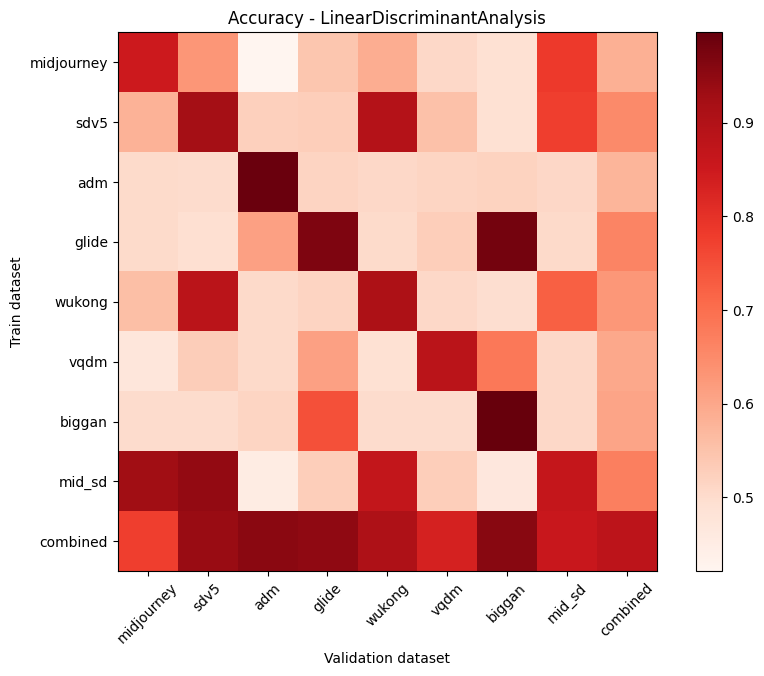

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.84875,0.63000,0.42125,0.54375,0.58750,0.50750,0.48875,0.785000,0.583929
sdv5,0.58000,0.92375,0.52250,0.52875,0.89375,0.55375,0.48875,0.775000,0.652143
adm,0.50250,0.50000,0.99000,0.51750,0.50875,0.51375,0.52000,0.509375,0.574107
glide,0.50375,0.49125,0.61125,0.96875,0.50375,0.52875,0.97875,0.505000,0.660000
wukong,0.55750,0.88375,0.50625,0.51625,0.90750,0.50875,0.49625,0.724375,0.626071
vqdm,0.47125,0.53000,0.50625,0.61125,0.48875,0.88375,0.68250,0.507500,0.597143
biggan,0.50000,0.50125,0.51375,0.74750,0.50125,0.50125,0.99625,0.506875,0.605179
mid_sd,0.92875,0.94250,0.45125,0.52875,0.86625,0.52875,0.46750,0.865000,0.669286
combined,0.77500,0.93625,0.95500,0.94875,0.90500,0.83375,0.95625,0.855000,0.879286


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.84875,0.63000,0.42125,0.54375,0.58750,0.50750,0.48875,0.785000,0.601562
sdv5,0.58000,0.92375,0.52250,0.52875,0.89375,0.55375,0.48875,0.775000,0.658281
adm,0.50250,0.50000,0.99000,0.51750,0.50875,0.51375,0.52000,0.509375,0.570234
glide,0.50375,0.49125,0.61125,0.96875,0.50375,0.52875,0.97875,0.505000,0.636406
wukong,0.55750,0.88375,0.50625,0.51625,0.90750,0.50875,0.49625,0.724375,0.637578
vqdm,0.47125,0.53000,0.50625,0.61125,0.48875,0.88375,0.68250,0.507500,0.585156
biggan,0.50000,0.50125,0.51375,0.74750,0.50125,0.50125,0.99625,0.506875,0.596016
mid_sd,0.92875,0.94250,0.45125,0.52875,0.86625,0.52875,0.46750,0.865000,0.697344
combined,0.77500,0.93625,0.95500,0.94875,0.90500,0.83375,0.95625,0.855000,0.895625


In [14]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy")

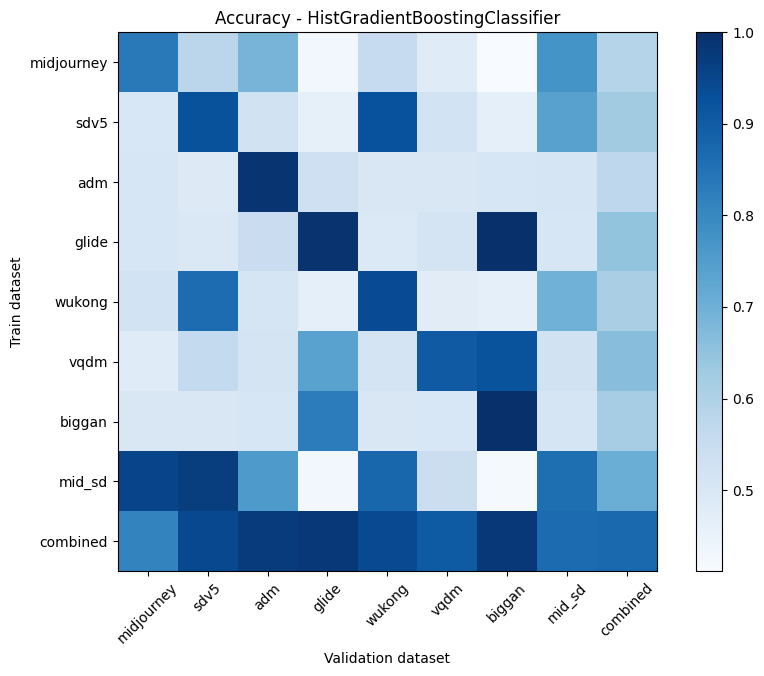

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.83375,0.57750,0.68750,0.42875,0.55625,0.48250,0.41125,0.773125,0.586250
sdv5,0.50250,0.92250,0.52375,0.46000,0.92625,0.52000,0.46625,0.739375,0.624286
adm,0.50625,0.48875,0.98875,0.53500,0.49875,0.50000,0.50625,0.509375,0.572679
glide,0.50375,0.49750,0.54625,0.99250,0.49250,0.51250,0.99750,0.504375,0.647500
wukong,0.52000,0.86375,0.51000,0.46375,0.93625,0.47750,0.46375,0.697500,0.610714
vqdm,0.48125,0.56250,0.51625,0.73625,0.51375,0.90375,0.92000,0.523750,0.663750
biggan,0.50000,0.50000,0.50375,0.82750,0.49875,0.50250,1.00000,0.508125,0.616964
mid_sd,0.95375,0.96875,0.75625,0.42625,0.87625,0.54125,0.42000,0.857500,0.706786
combined,0.81000,0.94375,0.97250,0.98000,0.94125,0.90125,0.98000,0.865000,0.872500


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.83375,0.57750,0.68750,0.42875,0.55625,0.48250,0.41125,0.773125,0.593828
sdv5,0.50250,0.92250,0.52375,0.46000,0.92625,0.52000,0.46625,0.739375,0.632578
adm,0.50625,0.48875,0.98875,0.53500,0.49875,0.50000,0.50625,0.509375,0.566641
glide,0.50375,0.49750,0.54625,0.99250,0.49250,0.51250,0.99750,0.504375,0.630859
wukong,0.52000,0.86375,0.51000,0.46375,0.93625,0.47750,0.46375,0.697500,0.616563
vqdm,0.48125,0.56250,0.51625,0.73625,0.51375,0.90375,0.92000,0.523750,0.644687
biggan,0.50000,0.50000,0.50375,0.82750,0.49875,0.50250,1.00000,0.508125,0.605078
mid_sd,0.95375,0.96875,0.75625,0.42625,0.87625,0.54125,0.42000,0.857500,0.725000
combined,0.81000,0.94375,0.97250,0.98000,0.94125,0.90125,0.98000,0.865000,0.924219


In [15]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Validation", metric="accuracy")

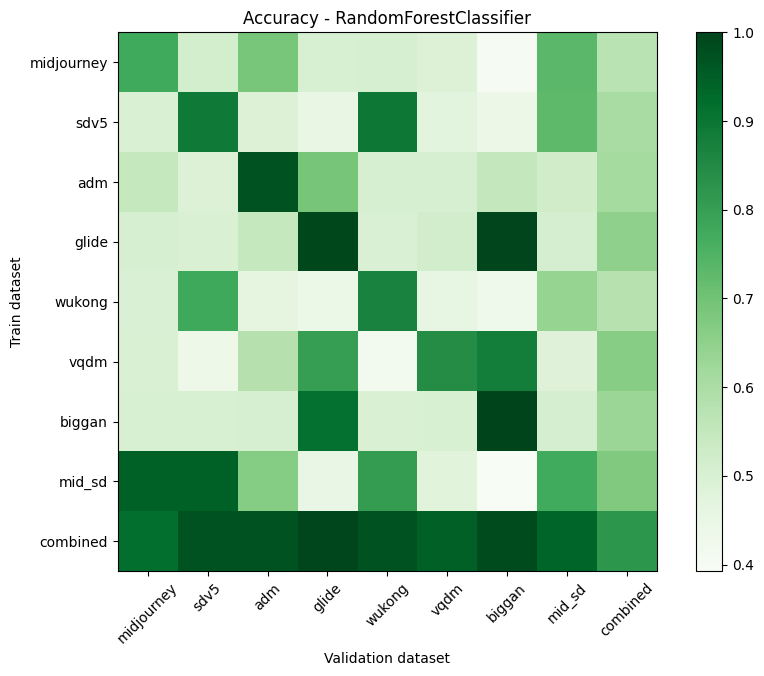

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.77375,0.51250,0.68750,0.50000,0.50375,0.49000,0.39875,0.733125,0.571964
sdv5,0.49875,0.88875,0.48875,0.45625,0.89500,0.47250,0.43875,0.728125,0.603929
adm,0.54750,0.49000,0.97125,0.69125,0.50250,0.50250,0.55000,0.521875,0.610357
glide,0.50500,0.49750,0.54500,0.99125,0.49500,0.51750,0.99750,0.507500,0.650893
wukong,0.49625,0.77875,0.46625,0.44250,0.86750,0.45750,0.42875,0.638750,0.576964
vqdm,0.49875,0.43375,0.57875,0.80250,0.41250,0.84500,0.88125,0.484375,0.661964
biggan,0.50125,0.50000,0.50375,0.91125,0.49875,0.50125,1.00000,0.508125,0.627679
mid_sd,0.94375,0.94500,0.66625,0.45125,0.80750,0.47750,0.39250,0.770000,0.675893
combined,0.91625,0.97000,0.97125,0.99375,0.97375,0.94625,0.98375,0.936875,0.820179


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.77375,0.51250,0.68750,0.50000,0.50375,0.49000,0.39875,0.733125,0.574922
sdv5,0.49875,0.88875,0.48875,0.45625,0.89500,0.47250,0.43875,0.728125,0.608359
adm,0.54750,0.49000,0.97125,0.69125,0.50250,0.50250,0.55000,0.521875,0.597109
glide,0.50500,0.49750,0.54500,0.99125,0.49500,0.51750,0.99750,0.507500,0.632031
wukong,0.49625,0.77875,0.46625,0.44250,0.86750,0.45750,0.42875,0.638750,0.572031
vqdm,0.49875,0.43375,0.57875,0.80250,0.41250,0.84500,0.88125,0.484375,0.617109
biggan,0.50125,0.50000,0.50375,0.91125,0.49875,0.50125,1.00000,0.508125,0.615547
mid_sd,0.94375,0.94500,0.66625,0.45125,0.80750,0.47750,0.39250,0.770000,0.681719
combined,0.91625,0.97000,0.97125,0.99375,0.97375,0.94625,0.98375,0.936875,0.961484


In [16]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Validation", metric="accuracy")

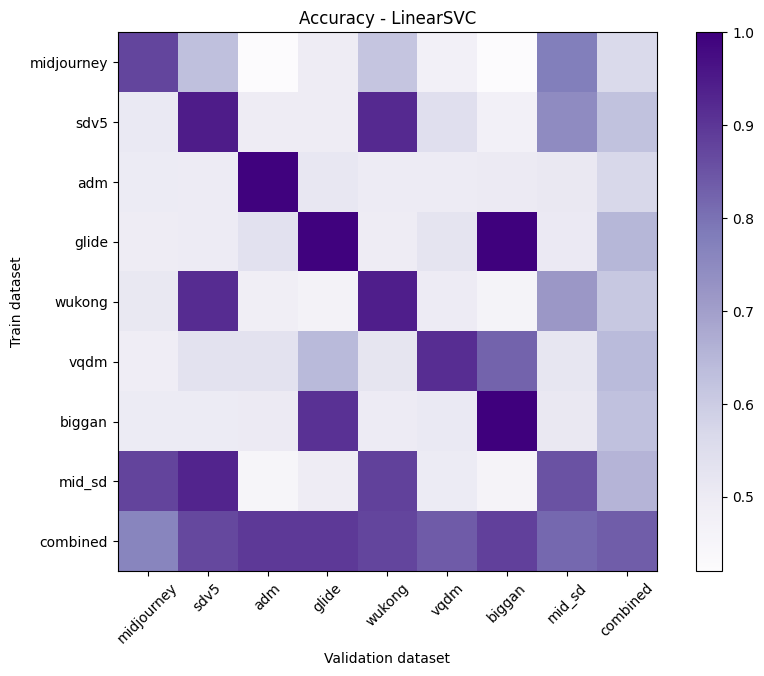

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.87375,0.62875,0.42000,0.49625,0.61500,0.47375,0.42000,0.777500,0.563214
sdv5,0.50750,0.94625,0.49375,0.49625,0.92125,0.54375,0.47375,0.745625,0.625000
adm,0.50125,0.49875,0.99375,0.51500,0.49875,0.49875,0.50250,0.508750,0.569464
glide,0.49500,0.49750,0.53625,0.99375,0.49250,0.52625,0.99750,0.505000,0.648929
wukong,0.51125,0.91625,0.48375,0.46625,0.94250,0.49875,0.46125,0.715000,0.608571
vqdm,0.49125,0.53375,0.53125,0.64250,0.52375,0.91500,0.82375,0.518125,0.640357
biggan,0.50000,0.50000,0.50375,0.90875,0.49875,0.50625,1.00000,0.508750,0.626964
mid_sd,0.87625,0.93000,0.45125,0.49500,0.88000,0.50125,0.45625,0.852500,0.655536
combined,0.76125,0.86875,0.89375,0.89375,0.87500,0.83750,0.88250,0.815000,0.834107


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.87375,0.62875,0.42000,0.49625,0.61500,0.47375,0.42000,0.777500,0.588125
sdv5,0.50750,0.94625,0.49375,0.49625,0.92125,0.54375,0.47375,0.745625,0.641016
adm,0.50125,0.49875,0.99375,0.51500,0.49875,0.49875,0.50250,0.508750,0.564688
glide,0.49500,0.49750,0.53625,0.99375,0.49250,0.52625,0.99750,0.505000,0.630469
wukong,0.51125,0.91625,0.48375,0.46625,0.94250,0.49875,0.46125,0.715000,0.624375
vqdm,0.49125,0.53375,0.53125,0.64250,0.52375,0.91500,0.82375,0.518125,0.622422
biggan,0.50000,0.50000,0.50375,0.90875,0.49875,0.50625,1.00000,0.508750,0.615781
mid_sd,0.87625,0.93000,0.45125,0.49500,0.88000,0.50125,0.45625,0.852500,0.680313
combined,0.76125,0.86875,0.89375,0.89375,0.87500,0.83750,0.88250,0.815000,0.853437


In [17]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Validation", metric="accuracy")

## Evaluate on test data

In [18]:
X_test = {}
y_test = {}

for key, df in datasets_test.items():
    X_test[key] = df.drop('Category', axis=1)
    y_test[key] = df['Category']

In [19]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nTest set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Test set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.5020
F1: 0.3378
Precision: 0.7505
Recall: 0.5020
MCC: 0.0448

Model: LinearDiscriminantAnalysis
Accuracy: 0.5040
F1: 0.3473
Precision: 0.6010
Recall: 0.5040
MCC: 0.0402

Model: RandomForestClassifier
Accuracy: 0.5020
F1: 0.3378
Precision: 0.7505
Recall: 0.5020
MCC: 0.0448

Model: LinearSVC
Accuracy: 0.5020
F1: 0.3378
Precision: 0.7505
Recall: 0.5020
MCC: 0.0448


Test set: sdv5



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3351
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4980
F1: 0.3377
Precision: 0.4370
Recall: 0.4980
MCC: -0.0225



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3674
Precision: 0.7244
Recall: 0.5150
MCC: 0.1160

Model: RandomForestClassifier
Accuracy: 0.5040
F1: 0.3422
Precision: 0.7510
Recall: 0.5040
MCC: 0.0634

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.8630
F1: 0.8604
Precision: 0.8925
Recall: 0.8630
MCC: 0.7549

Model: LinearDiscriminantAnalysis
Accuracy: 0.7550
F1: 0.7399
Precision: 0.8322
Recall: 0.7550
MCC: 0.5821

Model: RandomForestClassifier
Accuracy: 0.9300
F1: 0.9297
Precision: 0.9386
Recall: 0.9300
MCC: 0.8686

Model: LinearSVC
Accuracy: 0.8990
F1: 0.8980
Precision: 0.9160
Recall: 0.8990
MCC: 0.8148


Test set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5040
F1: 0.3439
Precision: 0.6677
Recall: 0.5040
MCC: 0.0518



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316


Test set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5020
F1: 0.3395
Precision: 0.6255
Recall: 0.5020
MCC: 0.0317



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6236
F1: 0.5614
Precision: 0.7852
Recall: 0.6236
MCC: 0.3755

Model: LinearDiscriminantAnalysis
Accuracy: 0.6101
F1: 0.5418
Precision: 0.7729
Recall: 0.6101
MCC: 0.3468

Model: RandomForestClassifier
Accuracy: 0.6337
F1: 0.5770
Precision: 0.7886
Recall: 0.6337
MCC: 0.3929

Model: LinearSVC
Accuracy: 0.6296
F1: 0.5707
Precision: 0.7872
Recall: 0.6296
MCC: 0.3858




 *** Evaluating models trained on vqdm. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9240
F1: 0.9238
Precision: 0.9276
Recall: 0.9240
MCC: 0.8516

Model: LinearDiscriminantAnalysis
Accuracy: 0.7120
F1: 0.7007
Precision: 0.7496
Recall: 0.7120
MCC: 0.4600

Model: RandomForestClassifier
Accuracy: 0.8840
F1: 0.8826
Precision: 0.9028
Recall

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5070
F1: 0.3634
Precision: 0.5718
Recall: 0.5070
MCC: 0.0448

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5360
F1: 0.4101
Precision: 0.7462
Recall: 0.5360
MCC: 0.1883

Model: LinearDiscriminantAnalysis
Accuracy: 0.6170
F1: 0.5551
Precision: 0.7638
Recall: 0.6170
MCC: 0.3514

Model: RandomForestClassifier
Accuracy: 0.5490
F1: 0.4351
Precision: 0.7531
Recall: 0.5490
MCC: 0.2227

Model: LinearSVC
Accuracy: 0.5280
F1: 0.3942
Precision: 0.7405
Recall: 0.5280
MCC: 0.1641


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9980
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
MCC: 0.9960

Model: LinearDiscriminantAnalysis
Accuracy: 0.9780
F1: 0.9780
Precision: 0.9782
Recall: 0.9780
MCC: 0.9562

Model: RandomForestClassifier
Accuracy: 0.9970
F1: 0.9970
Precision: 0.9970
Recall: 0.9970
MCC: 0.9940

Model: LinearSVC
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9940
Recall: 0.9940
MCC: 0.9880


Test set: midjourney

Model: HistGradientBoo

In [20]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="test_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

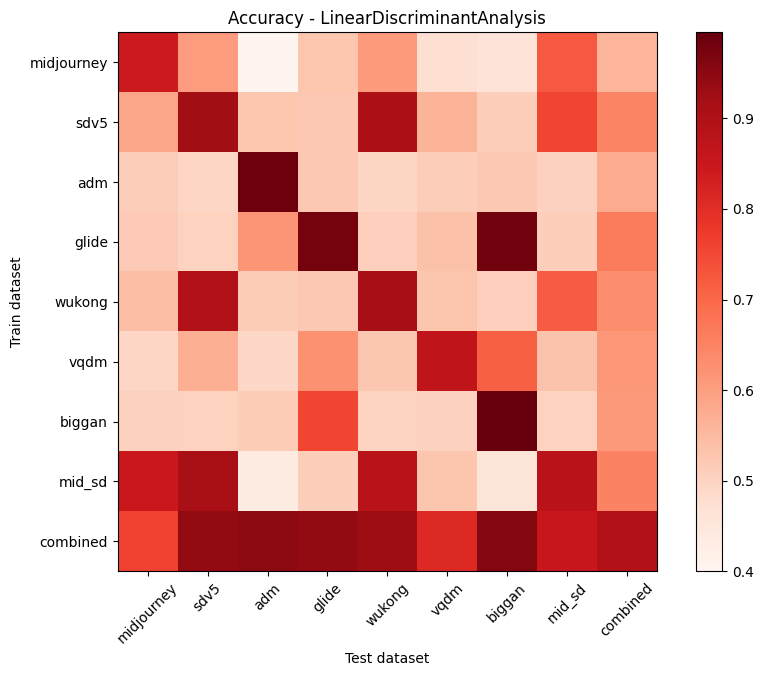

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.843,0.605,0.400,0.526,0.608,0.473,0.459,0.7240,0.559143
sdv5,0.586,0.925,0.527,0.521,0.904,0.561,0.511,0.7555,0.647857
adm,0.512,0.495,0.987,0.523,0.497,0.512,0.522,0.5035,0.578286
glide,0.518,0.501,0.617,0.978,0.507,0.537,0.981,0.5095,0.662714
wukong,0.542,0.897,0.515,0.521,0.920,0.530,0.509,0.7195,0.633429
vqdm,0.493,0.571,0.489,0.625,0.525,0.871,0.712,0.5320,0.612286
biggan,0.504,0.500,0.515,0.755,0.498,0.504,0.995,0.5020,0.610143
mid_sd,0.848,0.911,0.432,0.510,0.882,0.528,0.457,0.8795,0.652571
combined,0.758,0.940,0.947,0.941,0.926,0.808,0.960,0.8490,0.897143


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.843,0.605,0.400,0.526,0.608,0.473,0.459,0.7240,0.579750
sdv5,0.586,0.925,0.527,0.521,0.904,0.561,0.511,0.7555,0.661312
adm,0.512,0.495,0.987,0.523,0.497,0.512,0.522,0.5035,0.568938
glide,0.518,0.501,0.617,0.978,0.507,0.537,0.981,0.5095,0.643563
wukong,0.542,0.897,0.515,0.521,0.920,0.530,0.509,0.7195,0.644188
vqdm,0.493,0.571,0.489,0.625,0.525,0.871,0.712,0.5320,0.602250
biggan,0.504,0.500,0.515,0.755,0.498,0.504,0.995,0.5020,0.596625
mid_sd,0.848,0.911,0.432,0.510,0.882,0.528,0.457,0.8795,0.680937
combined,0.758,0.940,0.947,0.941,0.926,0.808,0.960,0.8490,0.891125


In [21]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Test", metric="accuracy")

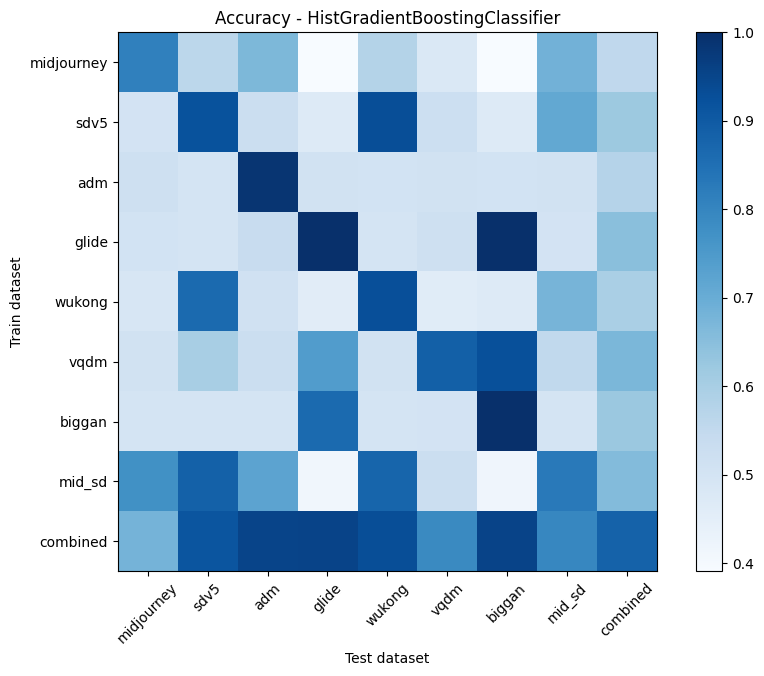

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.810,0.560,0.668,0.391,0.577,0.480,0.393,0.6850,0.554143
sdv5,0.502,0.921,0.525,0.470,0.930,0.523,0.469,0.7115,0.620000
adm,0.516,0.498,0.988,0.509,0.504,0.507,0.503,0.5070,0.575000
glide,0.503,0.499,0.536,0.998,0.500,0.516,0.999,0.5010,0.650143
wukong,0.490,0.863,0.510,0.459,0.927,0.461,0.469,0.6765,0.597000
vqdm,0.506,0.598,0.527,0.743,0.507,0.886,0.924,0.5520,0.670143
biggan,0.500,0.500,0.500,0.863,0.500,0.502,1.000,0.5000,0.623571
mid_sd,0.772,0.884,0.722,0.411,0.875,0.528,0.417,0.8280,0.658429
combined,0.681,0.914,0.951,0.953,0.929,0.790,0.954,0.7975,0.881714


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.810,0.560,0.668,0.391,0.577,0.480,0.393,0.6850,0.570500
sdv5,0.502,0.921,0.525,0.470,0.930,0.523,0.469,0.7115,0.631437
adm,0.516,0.498,0.988,0.509,0.504,0.507,0.503,0.5070,0.566500
glide,0.503,0.499,0.536,0.998,0.500,0.516,0.999,0.5010,0.631500
wukong,0.490,0.863,0.510,0.459,0.927,0.461,0.469,0.6765,0.606938
vqdm,0.506,0.598,0.527,0.743,0.507,0.886,0.924,0.5520,0.655375
biggan,0.500,0.500,0.500,0.863,0.500,0.502,1.000,0.5000,0.608125
mid_sd,0.772,0.884,0.722,0.411,0.875,0.528,0.417,0.8280,0.679625
combined,0.681,0.914,0.951,0.953,0.929,0.790,0.954,0.7975,0.871188


In [22]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Test", metric="accuracy")

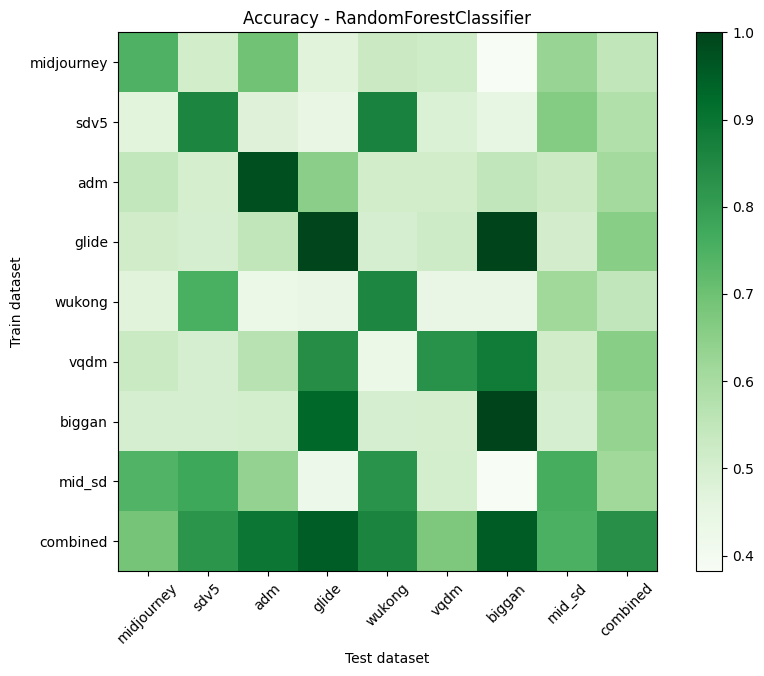

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.748,0.510,0.694,0.467,0.525,0.515,0.382,0.6290,0.548714
sdv5,0.466,0.859,0.474,0.446,0.867,0.484,0.449,0.6625,0.577857
adm,0.544,0.502,0.976,0.652,0.511,0.510,0.547,0.5230,0.606000
glide,0.514,0.500,0.549,0.997,0.500,0.521,1.000,0.5070,0.654429
wukong,0.469,0.755,0.433,0.440,0.856,0.441,0.438,0.6120,0.547429
vqdm,0.529,0.499,0.566,0.840,0.434,0.827,0.884,0.5140,0.654143
biggan,0.500,0.500,0.504,0.930,0.500,0.502,1.000,0.5000,0.633714
mid_sd,0.743,0.777,0.637,0.426,0.825,0.503,0.384,0.7600,0.613571
combined,0.687,0.819,0.895,0.950,0.861,0.675,0.953,0.7530,0.834286


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.748,0.510,0.694,0.467,0.525,0.515,0.382,0.6290,0.558750
sdv5,0.466,0.859,0.474,0.446,0.867,0.484,0.449,0.6625,0.588437
adm,0.544,0.502,0.976,0.652,0.511,0.510,0.547,0.5230,0.595625
glide,0.514,0.500,0.549,0.997,0.500,0.521,1.000,0.5070,0.636000
wukong,0.469,0.755,0.433,0.440,0.856,0.441,0.438,0.6120,0.555500
vqdm,0.529,0.499,0.566,0.840,0.434,0.827,0.884,0.5140,0.636625
biggan,0.500,0.500,0.504,0.930,0.500,0.502,1.000,0.5000,0.617000
mid_sd,0.743,0.777,0.637,0.426,0.825,0.503,0.384,0.7600,0.631875
combined,0.687,0.819,0.895,0.950,0.861,0.675,0.953,0.7530,0.824125


In [23]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Test", metric="accuracy")

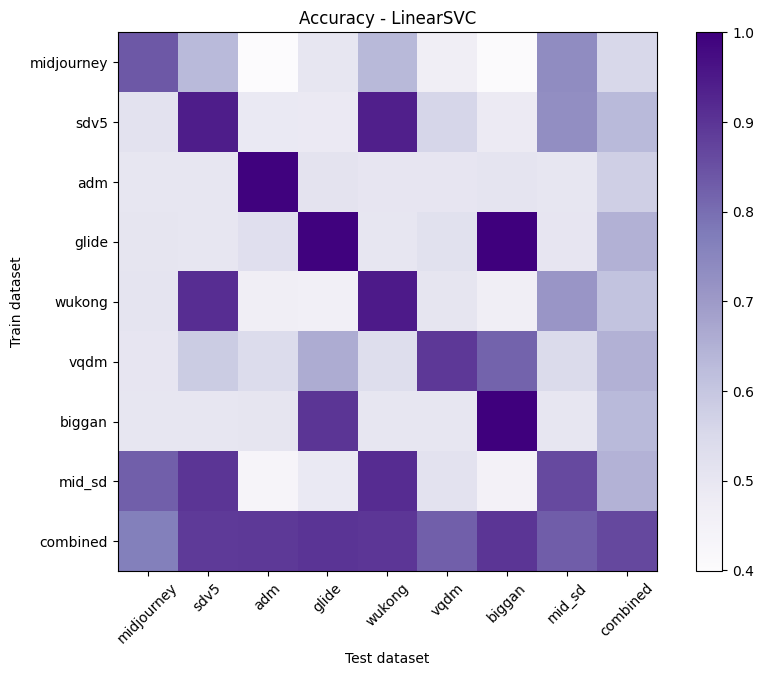

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.836,0.631,0.399,0.501,0.633,0.467,0.403,0.7335,0.552857
sdv5,0.515,0.942,0.489,0.486,0.937,0.559,0.485,0.7285,0.630429
adm,0.501,0.502,0.995,0.512,0.503,0.504,0.509,0.5015,0.575143
glide,0.506,0.500,0.528,0.994,0.500,0.523,1.000,0.5030,0.650143
wukong,0.508,0.912,0.465,0.461,0.948,0.505,0.466,0.7100,0.609286
vqdm,0.504,0.585,0.540,0.661,0.534,0.894,0.819,0.5445,0.648143
biggan,0.501,0.500,0.505,0.899,0.500,0.502,1.000,0.5005,0.629571
mid_sd,0.825,0.899,0.432,0.489,0.914,0.515,0.449,0.8620,0.646143
combined,0.766,0.888,0.891,0.900,0.895,0.824,0.899,0.8270,0.866143


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.836,0.631,0.399,0.501,0.633,0.467,0.403,0.7335,0.575438
sdv5,0.515,0.942,0.489,0.486,0.937,0.559,0.485,0.7285,0.642688
adm,0.501,0.502,0.995,0.512,0.503,0.504,0.509,0.5015,0.565937
glide,0.506,0.500,0.528,0.994,0.500,0.523,1.000,0.5030,0.631750
wukong,0.508,0.912,0.465,0.461,0.948,0.505,0.466,0.7100,0.621875
vqdm,0.504,0.585,0.540,0.661,0.534,0.894,0.819,0.5445,0.635188
biggan,0.501,0.500,0.505,0.899,0.500,0.502,1.000,0.5005,0.613437
mid_sd,0.825,0.899,0.432,0.489,0.914,0.515,0.449,0.8620,0.673125
combined,0.766,0.888,0.891,0.900,0.895,0.824,0.899,0.8270,0.861250


In [24]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Test", metric="accuracy")

## Save models and scalers

In [25]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/GenImage/standardJpg100/{dataset_name}"
        scalers_dir_path = f"scalers/GenImage/standardJpg100/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))